# Исследование объявлений о продаже квартир

В качестве исходных данных имеем сводку сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Проведем исследовательский анализ полученных данных. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общие данные. 

Загрузим датасет и посмотрим на первые 10 строк:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Посмотрим на общую информацию об исходной таблице:

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

Видим пропуски во многих столбцах. Это нормальная ситуация для таких данных. Ведь они строятся на заполнении параметров квартиры множеством разных людей. При этом все характеристики квартиры для публикации объявления указывать необязательно.

Однако часть таблицы заполняется автоматически на основе картографических данных, и там тоже есть пропуски, и немало. Прежде чем переходить  решению основной задачи, произведем предобработку данных, более пристально рассмотрим случаи с пропущенными данными и заполним пропуски там, где это целесообразно.

### Предобработка данных

Рассмотрим по порядку все столбцы, в которых присутствуют пропуски и разберемся, удастся ли их заполнить.

Применим метод *desribe()* для того, чтобы посмотреть как распределяется высота потолков в столбце *ceiling_height*

In [3]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медианное значение составляет **2,65** метра. Среднее значение отличается от него не критично, но видим выбросы со значением высоты потолков в **1** и **100** метров. При этом, содержимое столбца потребуется нам для дальнейшего анализа. Поэтому заполним значения высоты потолков медианными значениями.

Количество пропусков для этой величины довольно внушительное - **9195**, но вполне объяснимое. Далеко не каждый владелец недвижимости точно знает высоту потолков в своей квартире.
Разделим исходный датасет по дополнительному признаку для заполнения медианными значениями. Возьмем в качестве этого признака количество этажей. Исходим из того, что есть много типовой застройки (5 этажей, 9 этажей) со схожими значениями высоты потолков. В то же время в частных домах и более новых многоэтажках потолки выше.

Для объявлений же, в которых неизвестна этажность дома, заполним пропуски общим медианным значением высоты потолка.

In [4]:
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head(20)

,median,count
floors_total,,
1.0,2.80,10
2.0,2.70,215
3.0,2.80,399
4.0,3.00,789
5.0,2.55,3666
6.0,3.00,619
7.0,3.00,398
8.0,2.80,220
9.0,2.55,2557


Видим подтверждение гипотезы. В типовых 5-ти и 9-ти этажках потолки высотой 2.55 метра, в частных домах и более новых и высотных строениях - выше. Также в значениях можно найти 1200 квартир в четырехэтажных зданиях с медианной высотой потолков в 3 метра - похоже на историческую застройку центральных районов Петербурга.

Произведем заполнение пропусков:

In [5]:
for floor in ceiling_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].median()

In [6]:
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']

Следующий столбец с пропусками - *floors_total*. Для 86 объявлений неизвестна этажность здания. Оставим пропуски незаполненными, а на этапе определения категории для этажей присвоим для этих строк тип *другой*

В данных столбца *living_area* без малого 2000 пропусков. Эта метрика важна для дальнейшего анализа цен на квартиры. Для того, чтобы заполнить пропуски, посмотрим на медианные значения жилой площади по количеству комнат.

In [7]:
median_living_area = data.groupby('rooms')['living_area'].median()
median_living_area

rooms
0      18.000
1      17.600
2      30.500
3      45.000
4      63.600
5      91.785
6     123.900
7     145.000
8     161.000
9     179.200
10    161.400
11    133.900
12    409.700
14    195.150
15    409.000
16    180.000
19    264.500
Name: living_area, dtype: float64

Обнаруживаем значение *0* в столбце *rooms*, для которого значение жилой площади сопоставимо со значениями для однокомнатных квартир. Количество комнат не может быть нулевым, вероятно, стоит заменить "нулекомнатные" квартиры на однокомнатные. Но прежде чем это делать, посмотрим на значения общей площади квартир со значением *0* в столбце *rooms*: 

count    197.000000
mean      29.279746
std       25.855264
min       15.500000
25%       24.050000
50%       26.050000
75%       28.400000
max      371.000000
Name: total_area, dtype: float64

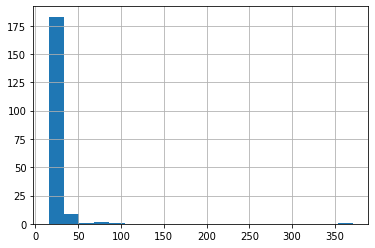

In [8]:
null_rooms = data.query('rooms == 0')
null_rooms['total_area'].hist(bins=20)
null_rooms['total_area'].describe()

Имеем 197 записей, абсолютное большинство которых укладывается в пределы 30 $м^{2}$. Теперь посмотрим на медианные значения общей площади, распределенные по количеству комнат:

In [9]:
median_total_area = data.groupby('rooms')['total_area'].median()
median_total_area

rooms
0      26.05
1      36.56
2      53.00
3      73.00
4      99.30
5     146.45
6     184.30
7     214.00
8     235.70
9     300.95
10    272.60
11    188.90
12    900.00
14    304.20
15    590.00
16    270.00
19    374.60
Name: total_area, dtype: float64

И на количество однокомнатных квартир в выборке

In [10]:
len(data[data['rooms'] == 1])

8047

Однокомнатные квартиры чуть больше, чем "нулекомнатные", но соотношение 197 к 8047 позволяет нам заменить значение *0* в столбце *rooms* на *1* и избежать искажения данных.

In [11]:
data['rooms'] = data['rooms'].replace(0, 1)

Найдем значения количества комнат для квартир, в которых не указана жилая площадь:

In [12]:
living_area_isnull = data[data['living_area'].isnull()]
living_area_isnull['rooms'].value_counts()

1    673
2    644
3    448
4     91
5     34
7      6
6      6
9      1
Name: rooms, dtype: int64

Наконец, заменим пустые значения в *living_area* медианными

In [13]:
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 1), 'living_area'] = median_living_area[1]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 2), 'living_area'] = median_living_area[2]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 3), 'living_area'] = median_living_area[3]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 4), 'living_area'] = median_living_area[4]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 5), 'living_area'] = median_living_area[5]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 6), 'living_area'] = median_living_area[6]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 7), 'living_area'] = median_living_area[7]
data.loc[(data['living_area'].isnull()) & (data['rooms'] == 9), 'living_area'] = median_living_area[9]

В столбце *is_apartment* имеем всего *2775* заполненных значений. Посмотрим на их распределение:

In [14]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Видим, что только в *1,8%* случаев из заполненных значений продаваемое помещение является апартаментами. Подавляющее большинство строк же и вовсе пусты.

Апартаменты - это нежилое помещение, которое, впрочем, может быть оборудовано и как квартира. Как правило, цена такой недвижимости ниже, чем у жилой. Но на рынке таких предложений довольно мало.

Подтверждение этому суждению мы видим и среди заполненных значений столбца. Несмотря на малое количество апартаментов среди заполненных значений, мы не можем утверждать, что все оставшиеся объекты недвижимости - не апартаменты. Оставим пустые значения в этом столбце в исходном виде.

Следующий в очереди на заполнение - столбец *kitchen_area*. Поступим аналогично с *living_area*. Заполним пустые значения медианными по количеству комнат.

In [15]:
median_kitchen_area = data.groupby('rooms')['kitchen_area'].median()
median_kitchen_area

rooms
1       9.04
2       8.80
3       9.50
4      11.10
5      15.10
6      19.50
7      20.00
8      25.00
9      14.30
10     19.80
11     12.60
12    112.00
14     21.25
15    100.00
16     13.00
19     27.60
Name: kitchen_area, dtype: float64

Полученные данные выглядят логично. Чем больше комнат и просторнее квартира - тем больше места в ней выделено для кухни. Зависимость перестает напрямую прослеживаться с количеством комнат от 8, но там и выборка значительно меньше.

In [16]:
kitchen_area_isnull = data[data['kitchen_area'].isnull()]
kitchen_area_isnull['rooms'].value_counts()

1    1031
2     654
3     434
4      99
5      41
6       8
7       7
8       3
9       1
Name: rooms, dtype: int64

In [17]:
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 1), 'kitchen_area'] = median_kitchen_area[1]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 2), 'kitchen_area'] = median_kitchen_area[2]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 3), 'kitchen_area'] = median_kitchen_area[3]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 4), 'kitchen_area'] = median_kitchen_area[4]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 5), 'kitchen_area'] = median_kitchen_area[5]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 6), 'kitchen_area'] = median_kitchen_area[6]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 7), 'kitchen_area'] = median_kitchen_area[7]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 8), 'kitchen_area'] = median_kitchen_area[8]
data.loc[(data['kitchen_area'].isnull()) & (data['rooms'] == 9), 'kitchen_area'] = median_kitchen_area[9]

Внушительное количество пропусков видим в столбце *balcony*. Примем их за отсутствие балкона в квартире.

Заполним пропуски нулевыми значениями:

In [18]:
data.loc[data['balcony'].isnull(), 'balcony'] = 0

В 49 строках отсутствует информация в столбце *locality_name*

Местоположение - один из самых важных факторов, влияющих на цену квартиры. Заполнить эти пропуски без дополнительной информации не представляется возможным, поэтому удалим из датасета объявления, для которых неизвестна локация продаваемой квартиры.

In [19]:
data.dropna(subset=['locality_name'], inplace = True)

В столбце *days_exposition* видим 3180 пропусков. Предположим, что эти объявления еще не сняты с публикации на сайте. Мы не знаем, когда была произведена выгрузка, поэтому оставим пропуски в данных в исходном виде.

Все нерассмотренные выше столбцы с пропусками заполняются автоматически на основе картографических данных. Не зная алгоритмов и правил заполнения мы не сможем достоверно предположить, почему значения остаются пустыми. Соберем данные о пропусках и направим их представителю заказчика. Возможно получим уточнения и сможем заполнить пропущенные значения.

В задании картографические данные нам необходимы для двух целей:
- определение зависимости цены на квартиру от удаленности от центра города
- выделение центральной части города Санкт-Петербург по величине расстояния
Посмотрим, для скольких объявлений в Санкт-Петербурге есть данные о расстоянии до центра и каково их общее количество.

In [20]:
spb_flats = data.query('locality_name == "Санкт-Петербург"')
spb_flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15721 entries, 0 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          15721 non-null  int64  
 1   last_price            15721 non-null  float64
 2   total_area            15721 non-null  float64
 3   first_day_exposition  15721 non-null  object 
 4   rooms                 15721 non-null  int64  
 5   ceiling_height        15721 non-null  float64
 6   floors_total          15651 non-null  float64
 7   living_area           15721 non-null  float64
 8   floor                 15721 non-null  int64  
 9   is_apartment          1833 non-null   object 
 10  studio                15721 non-null  bool   
 11  open_plan             15721 non-null  bool   
 12  kitchen_area          15721 non-null  float64
 13  balcony               15721 non-null  float64
 14  locality_name         15721 non-null  object 
 15  airports_nearest   

Здесь обнаруживается особенность данных, полученных автоматически. Для Санкт-Петербурга по абсолютному большинству объявлений данные присутствуют. В частности в столбце *cityCenters_nearest* всего 61 пропуск.

Вероятно, не для всех населенных пунктов размечены центры, парки, пруды и ближайшие аэропорты. Добавим информацию о полученном наблюдении в письмо для заказчика.

По-прежнему большое количество пропусков в столбцах *parks_nearest* и *ponds_nearest*. Так как на данном этапе изучение содержимого этих столбцов не требуется, ограничимся предпринятыми выше действиями по информированию заказчика.

Далее изучим значения, содержащиеся в заполненных строках столбца *cityCenters_nearest*


In [21]:
median_distance_to_center = data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc=['median', 'count'])
median_distance_to_center.columns = ['median', 'count']
median_distance_to_center.sort_values(by='count', ascending=False).head(20)

,median,count
Санкт-Петербург,12244.5,15660
посёлок Шушары,24212.0,436
Пушкин,27930.5,368
Колпино,32018.0,337
посёлок Парголово,19311.0,327
Петергоф,33771.0,201
Сестрорецк,34821.0,183
Красное Село,29140.5,176
Ломоносов,51677.0,132
Кронштадт,49575.0,95


Судя по значениям расстояний до центра, в исходном датасете имеем расстояния от всех населенных пунктов до центра Санкт-Петербурга. Расстояние в пределах одного города до центра Санкт-Петербурга будет изменяться незначительно. Доля же пропусков значений расстояния до центра в самом Санкт-петербурге составляет **0,4%**.
Заменим пропущенные данные в столбце *cityCenters_nearest* медианными значениями:

In [22]:
median_distance = data.groupby(['locality_name'])
data['cityCenters_nearest'] = median_distance.cityCenters_nearest.apply(lambda x: x.fillna(x.median()))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Заполнилось только 84 пропуска. Посмотрим на названия населенных пунктов, для которых нет данных о расстоянии до центра.

In [23]:
nan_center_distance = data[data['cityCenters_nearest'].isna()]
nan_center_distance = nan_center_distance['locality_name'].value_counts()
nan_center_distance.head()

посёлок Мурино     522
Всеволожск         398
Гатчина            307
деревня Кудрово    299
Выборг             237
Name: locality_name, dtype: int64

Сразу бросается в глаза запись "посёлок Мурино" с 522 пропусками. Среди заполненных строк есть "поселок Мурино" с 34 значениями.

Переименуем "посёлок Мурино" в "поселок Мурино" и присвоим медианные значения расстояния до центра.

In [24]:
data.loc[data['locality_name'] == 'посёлок Мурино', 'cityCenters_nearest'] = median_distance_to_center.loc['поселок Мурино', 'median']
data['locality_name'] = data['locality_name'].replace('посёлок Мурино', 'поселок Мурино')

Также замечен дубликат среди названий населенных пунктов: "Кудрово" и "деревня Кудрово".

Заменим на "деревня Кудрово".

In [25]:
data['locality_name'] = data['locality_name'].replace('Кудрово', 'деревня Кудрово')

Для населенных пунктов из выборки *nan_center_distance*, количество квартир в которых больше 1% (237 объявлений) от общего количества заполним пропуск среднего значения расстояния до центра из внешнего источника вручную.

Для этого в Яндекс картах построим маршруты от каждого из населенных пунктов до Дворцовой площади в Санкт-Петербурге.

Получим следующие значения:
- Всеволожск - 27000 метров;
- Гатчина - 51000 метров;
- деревня Кудрово - 17000 метров;
- Выборг - 140000 метров.

In [26]:
data.loc[data['locality_name'] == 'Всеволожск', 'cityCenters_nearest'] = 27000
data.loc[data['locality_name'] == 'Гатчина', 'cityCenters_nearest'] = 51000
data.loc[data['locality_name'] == 'деревня Кудрово', 'cityCenters_nearest'] = 17000
data.loc[data['locality_name'] == 'Выборг', 'cityCenters_nearest'] = 140000

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

При помощи подстановки расстояний вручную для значимых количественно групп и замен медианными значениями, там где это возможно, получилось заполнить порядка **2000** значений в столбце *cityCenters_nearest*

Перейдем к замене типов данных:

Мы можем заменить типы в столбцах *last_price* и *balcony* на *int64*, так как это целочисленные значения и среди них нет пропусков.

В остальных столбцах, где подразумеваются целочисленные значения, есть пропуски, поэтому оставим данные в исходном виде.

Можно было бы заменить тип данных столбца *is_apartment* на *bool*, ведь в нем содержатся только значения "True" и "False", но тогда всем пропускам будет присвоено значение "True", что перевернет исходные данные с ног на голову.

Кроме того, можно преобразовать данные в *first_day_exposition* к *datetime*.

Заменим типы данных в определенных выше столбцах:

In [28]:
type_int = ['last_price', 'balcony']
data[type_int] = data[type_int].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int32         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

### Вывод

На этапе предобработки данных были заполнены пропуски, там где это возможно, изменены типы данных, обработаны обнаруженные в названиях населенных пунктов дубликаты.

Отдельно стоит обратить внимание на то, что удалось интерпретировать и подобрать логичные замены почти для всех столбцов, заполняемых людьми вручную, но не до конца ясна картинка с автоматически заполненными данными. Запросим информацию о заполнении на основе картографических данных у поставщиков датасета.

### Вычисление дополнительных параметров

Рассчитаем цену квадратного метра площади и добавим в исходную таблицу столбец *price_per_m2*

In [29]:
data['price_per_m2'] = data['last_price'] / data['total_area']

Выделим из даты первой экспозиции объявления день недели, месяц и год.

Результаты сохраним в столбцы:
- *exposition_weekday*
- *exposition_month*
- *exposition_year*

In [30]:
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

Разделим данные столбца *floor* на следующие категориии:
- первый (для первых этажей)
- последний (для последних этажей)
- другой (для всех остальных этажей)

Результаты сохраним в столбце *floor_category*

In [31]:
def floor_category(floor):
    if floor['floor'] == 1:
        return 'первый'
    if floor['floor'] == floor['floors_total']:
        return 'последний'
    return 'другой'
data['floor_category'] = data.apply(floor_category, axis=1)

Также добавим столбцы, содержащие отношение жилой площади и площади кухни к общей площади квартиры. Назовем их *living_part* и *kitchen_part* соответственно.

In [32]:
data['living_part'] = data['living_area'] / data['total_area']
data['kitchen_part'] = data['kitchen_area'] / data['total_area']

Оценим полученные результаты выведя общие данные о таблице и первые 10 строк:

In [33]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int32         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,exposition_weekday,exposition_month,exposition_year,floor_category,living_part,kitchen_part
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.75,11.0,18.6,1,NaN,...,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.55,5.0,34.3,4,NaN,...,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.60,14.0,45.0,9,NaN,...,3.0,234.0,424.0,408176.100629,4,7,2015,другой,0.283019,0.059748
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,1.0,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000


### Исследовательский анализ данных

Перед началом исследования распределения того или иного параметра, напишем функцию, которая будет определять границы "усов" диаграммы распределения для каждого исследуемого признака. 

In [34]:
def border_whiskers(column):
    
    #найдем значения 1 и 3 квартиля
    q1 = data[column].quantile(0.25)                 
    q3 = data[column].quantile(0.75)
    
    #iqr - межквартильный размах
    iqr = q3 - q1
    #найдем значения левого и правого "уса"
    left_whisker = round(q1 - 1.5 * iqr, 2)
    right_whisker = round(q3 + 1.5 * iqr, 2)
    
    #левый "ус" не может быть меньше минимального значения
    if left_whisker < data[column].min():
        left_whisker = data[column].min()
        
    #правый "ус" не может быть меньше максимального значения
    if right_whisker > data[column].max():
        right_whisker = data[column].max()
        
    return[left_whisker, right_whisker]

Начнем исследование со столбца *total_area*. Применим функцию *border_whiskers* и посмотрим на границы распределения:

In [35]:
border_whiskers('total_area')

[12.0, 114.25]

In [36]:
data['total_area'].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Видим, что минимальное значение вошло в границы диаграммы размаха, значит выбросы есть только среди квартир с большой площадью.

Построим диграмму размаха и убедимся, что функция работает верно. Для наглядности ограничим значения площади до 200 $м^{2}$.

(0, 200)

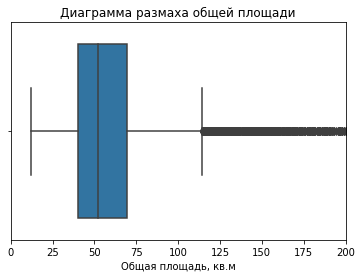

In [37]:
sns.boxplot(data['total_area'])
plt.title('Диаграмма размаха общей площади')
plt.xlabel('Общая площадь, кв.м')
plt.xlim(0, 200)

Действительно, все значения больше 115 $м^{2}$ выпадают за пределы правого "уса".

Построим гистограмму распределения общей площади. Ограничим максимальное значение 120 $м^{2}$

(0, 120)

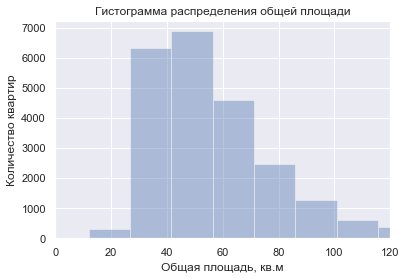

In [38]:
sns.set(style="darkgrid")
sns.distplot(data['total_area'], kde=False, bins=60)
plt.title('Гистограмма распределения общей площади')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Количество квартир')
plt.xlim(0, 120)

По гистограмме распределения можно сделать вывод, что наибольшее количество квартир на рынке укладывается в рамки 30 - 70 $м^{2}$, что соответствует 1 - 3-комнатным квартирам.

Добавим в исходную таблицу с данными новый столбец *area_out_of_borders*, в котором содержится признак выхода за пределы границ диаграммы размаха:

In [39]:
data['area_out_of_borders'] = data['total_area'] > border_whiskers('total_area')[1]

Применим функцию *border_whiskers* для столбца *last_price* и посмотрим на границы распределения цен на квартиры:

In [40]:
border_whiskers('last_price')

[12190, 11897500.0]

In [41]:
data['last_price'].describe().astype('int')

count        23650
mean       6541126
std       10896399
min          12190
25%        3400000
50%        4650000
75%        6799000
max      763000000
Name: last_price, dtype: int32

Минимальное значение вошло в границы диаграммы размаха, значит выбросы есть только среди квартир с высокой ценой.

Построим диаграмму размаха. Ограничим значение цены 14 млн. рублей.

(0, 14000000)

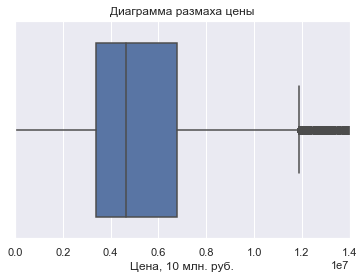

In [42]:
sns.boxplot(data['last_price'])
plt.title('Диаграмма размаха цены')
plt.xlabel('Цена, 10 млн. руб.')
plt.xlim(0, 14000000)

Построим гистограмму распределения, ограничим цену недвижимости 13 млн. рублей.

(0, 13000000)

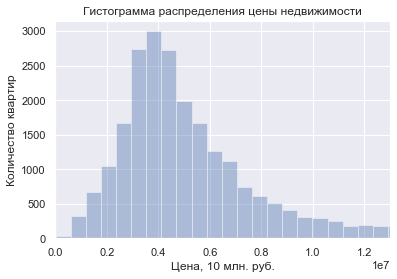

In [43]:
sns.set(style="darkgrid")
sns.distplot(data['last_price'], kde=False, bins=1300)
plt.title('Гистограмма распределения цены недвижимости')
plt.xlabel('Цена, 10 млн. руб.')
plt.ylabel('Количество квартир')
plt.xlim(0, 13000000)

Видим наибольшее количество квартир в ценовом диапазоне 3 - 6 млн. рублей.

Добавим в исходную таблицу с данными новый столбец *price_out_of_borders*, в котором содержится признак выхода за пределы границ диаграммы размаха:

In [44]:
data['price_out_of_borders'] = data['last_price'] > border_whiskers('last_price')[1]

Применим функцию *border_whiskers* для столбца *rooms* и посмотрим на границы распределения цен на квартиры:

In [45]:
border_whiskers('rooms')

[1, 6.0]

In [46]:
data['rooms'].describe()

count    23650.000000
mean         2.078436
std          1.066393
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Минимальное значение вошло в границы диаграммы размаха, значит выбросы есть только среди квартир с большим количеством комнат.

Построим диаграмму размаха. Ограничим значение количества комнат восемью.

(0, 8)

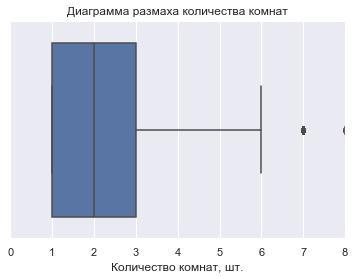

In [47]:
sns.boxplot(data['rooms'])
plt.title('Диаграмма размаха количества комнат')
plt.xlabel('Количество комнат, шт.')
plt.xlim(0, 8)

Построим гистограмму распределения. Ограничим количество комнат значением 7.

(0, 7)

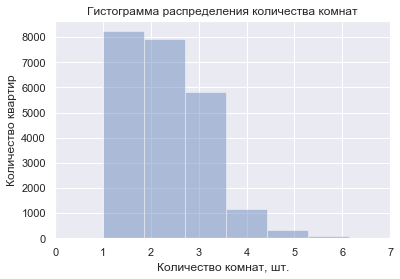

In [48]:
sns.distplot(data['rooms'], kde=False, bins=21)
plt.title('Гистограмма распределения количества комнат')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Количество квартир')
plt.xlim(0, 7)

Наиболее часто встречающиеся на рынке - квартиры с количеством комнат от 1 до 3.

Добавим в исходную таблицу с данными новый столбец *rooms_out_of_borders*, в котором содержится признак выхода за пределы границ диаграммы размаха:

In [49]:
data['rooms_out_of_borders'] = data['rooms'] > border_whiskers('rooms')[1]

Применим функцию *border_whiskers* для столбца *ceiling_height* и посмотрим на границы распределения высоты потолков в квартирах:

In [50]:
border_whiskers('ceiling_height')

[2.25, 3.05]

In [51]:
data['ceiling_height'].describe()

count    23650.000000
mean         2.735429
std          0.995219
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

Для высоты потолков видим выбросы и в нижней, и в верхней частях диапазона значений.

Построим диаграмму размаха. Ограничим значение высоты потолков величинами от 1 до 4 метров.

(1, 4)

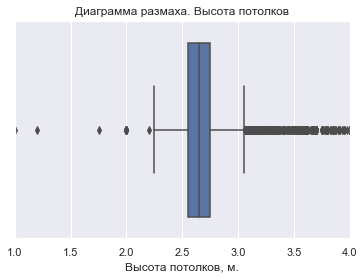

In [52]:
sns.boxplot(data['ceiling_height'])
plt.title('Диаграмма размаха. Высота потолков')
plt.xlabel('Высота потолков, м.')
plt.xlim(1, 4)

Построим гистограмму распределения. Возьмем для рассмотрения диапазон высоты потолков: 2,2 - 3,5 метра

(2.2, 3.5)

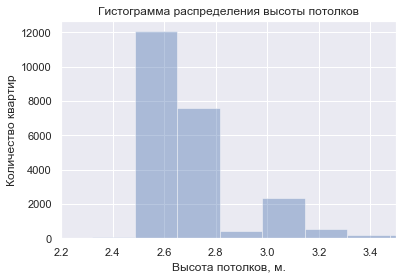

In [53]:
sns.distplot(data['ceiling_height'], kde=False, bins=600)
plt.title('Гистограмма распределения высоты потолков')
plt.xlabel('Высота потолков, м.')
plt.ylabel('Количество квартир')
plt.xlim(2.2, 3.5)

На гистограмме распределения видим, что большинство квартир попадают в интервал 2,55 - 2,8 метра по высоте потолков. Но заметен и пик в районе 3 метров, характеризующий историческую застройку в центре города и загородные коттеджи.

Добавим в исходную таблицу с данными новый столбец *ceiling_out_of_borders*, в котором содержится признак выхода за пределы границ диаграммы размаха:

In [54]:
data['ceiling_out_of_borders'] = (data['ceiling_height'] > border_whiskers('ceiling_height')[1]) | (data['ceiling_height'] < border_whiskers('ceiling_height')[0])

Рассмотрим данные в столбце *days_exposition*. Применим функцию border_whiskers и посмотрим на распределение сроков до снятия квартиры с публикации:

In [55]:
border_whiskers('days_exposition')

[1.0, 510.0]

In [56]:
data['days_exposition'].describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Построим гистограмму распределения значений времени экспозиции объявлений:

(0, 550)

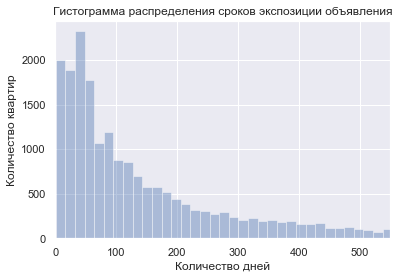

In [57]:
sns.distplot(data['days_exposition'], kde=False, bins=100)
plt.title('Гистограмма распределения сроков экспозиции объявления')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')
plt.xlim(0, 550)

Отметим для времени публикации объявления большое стандартное отклонение и практически вдвое отличающиеся медианное (**95 дней**) и среднее (**180 дней**) значения.

Можно сделать выводы, что половина квартир продается чуть больше, чем за 3 месяца. Быстрой же можно считать продажу, укладывающуюся по времени в 1 месяц. Долгой, в свою очередь, будет продажа квартиры более 8 месяцев.

Странным может показаться наличие публикаций, которые были закрыты за 1-2 дня, но без дополнительных данных невозможно оценить связано ли это с быстрой продажей, изменившимися внезапно обстоятельствами у продавца или мошенническими действиями.

Поэтому в новый столбец исходной таблицы *exposition_out_of_borders* добавим значения, выходящие за рамки диапазона, возвращаемого функцией *border_whiskers*

In [58]:
data['exposition_out_of_borders'] = data['days_exposition'] > border_whiskers('days_exposition')[1]

Удалим из исходной таблицы редкие и выбивающиеся значения:

In [59]:
good_data = data[(data['area_out_of_borders'] == False) & 
     (data['price_out_of_borders'] == False) &
     (data['rooms_out_of_borders'] == False) &
     (data['ceiling_out_of_borders'] == False) &
     (data['exposition_out_of_borders'] == False)].reset_index(drop=True)
print('Доля чистых значений от исходного датасета: {:.1%}'. format(len(good_data) / len(data)))

Доля чистых значений от исходного датасета: 81.4%


In [60]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19253 entries, 0 to 19252
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   total_images               19253 non-null  int64         
 1   last_price                 19253 non-null  int32         
 2   total_area                 19253 non-null  float64       
 3   first_day_exposition       19253 non-null  datetime64[ns]
 4   rooms                      19253 non-null  int64         
 5   ceiling_height             19253 non-null  float64       
 6   floors_total               19187 non-null  float64       
 7   living_area                19253 non-null  float64       
 8   floor                      19253 non-null  int64         
 9   is_apartment               2125 non-null   object        
 10  studio                     19253 non-null  bool          
 11  open_plan                  19253 non-null  bool          
 12  kitc

После удаления редких и выбивающихся значений по 5 разным признакам было отброшено **18,6%** объявлений. 

Выясним, какие факторы больше всего влияют на цену недвижимости. Построим графики зависимости цены продаваемых квартир от общей площади и расстояния до центра Санкт-Петербурга. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


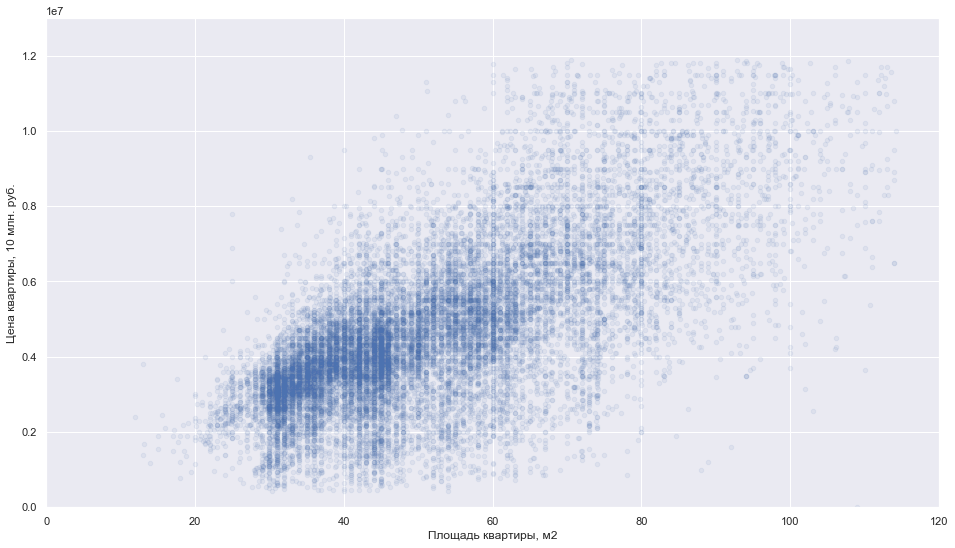

In [61]:
good_data.plot(x='total_area', y='last_price', 
               kind='scatter', alpha=0.08, 
               xlim=(0, 120), ylim=(0, 13000000), 
               figsize=(16, 9))
plt.xlabel("Площадь квартиры, м2")
plt.ylabel("Цена квартиры, 10 млн. руб.");

In [62]:
good_data['last_price'].corr(good_data['total_area'])

0.6812310498357379

Подтверждается довольно очевидное суждение. Чем больше площадь квартиры, тем больше ее цена.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


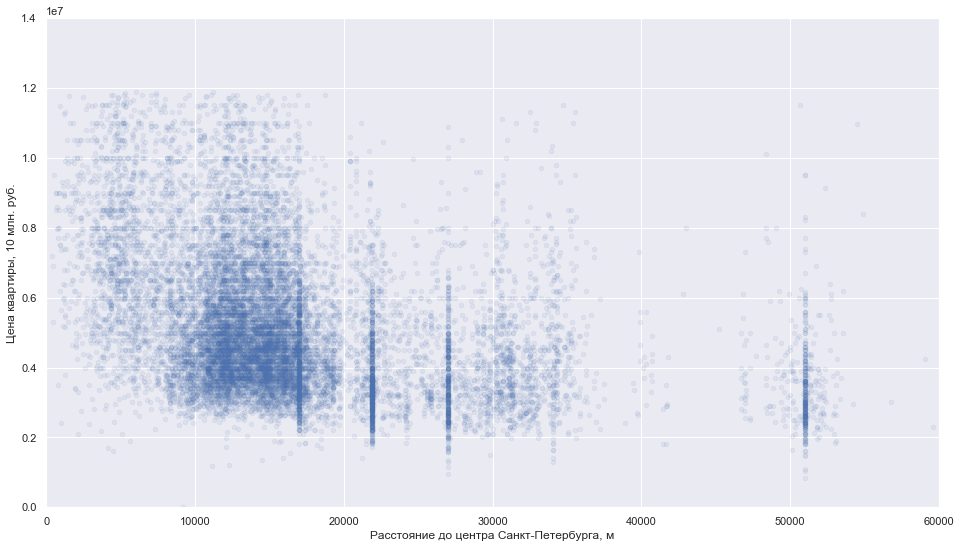

In [63]:
good_data.plot(x='cityCenters_nearest', y='last_price', 
               kind='scatter', alpha=0.08, 
               xlim=(0, 60000), ylim=(0, 14000000), 
               figsize=(16, 9))
plt.xlabel("Расстояние до центра Санкт-Петербурга, м")
plt.ylabel("Цена квартиры, 10 млн. руб.");

In [64]:
good_data['last_price'].corr(good_data['cityCenters_nearest'])

-0.2913901702940516

Между стоимостью квадратного метра и расстоянием до центра выявлена слабая отрицательная корреляция. Однако, если посмотреть на график зависимости величин, можно сделать вывод, что зависимость более выражена в пределах КАД (порядка 20 км) и практически сходит на нет за пределами Санкт-Петербурга и ближайших пригородов.

Построим диаграммы размаха, чтобы оценить как соотносится цена квартиры с количеством комнат, категорией этажа, а также днем недели, месяцем и годом публикации объявления.

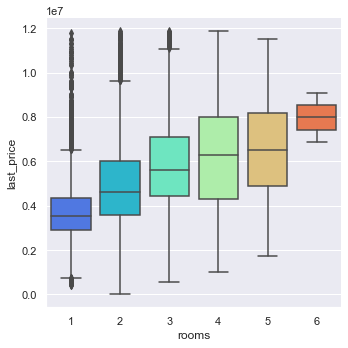

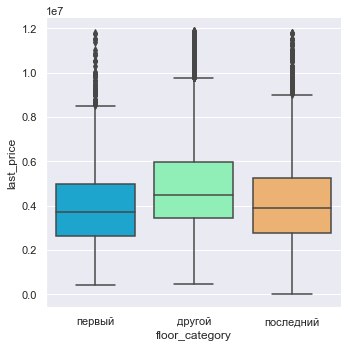

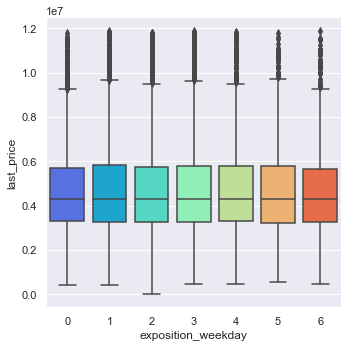

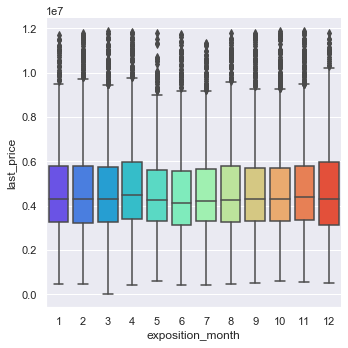

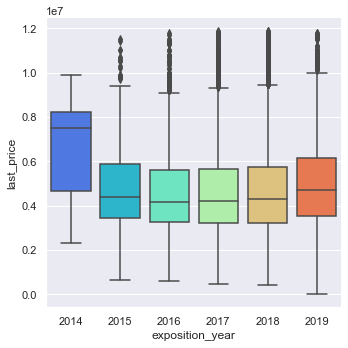

In [65]:
for column in ['rooms', 'floor_category', 'exposition_weekday', 'exposition_month', 'exposition_year']:
    sns.catplot(x=column, y="last_price", kind="box", data=good_data, palette='rainbow');

**Зависимость цены на недвижимость от количества комнат**

Прослеживается увеличение цены на квартиру с увеличением комнат в ней от одной до шести. При этом стоит обратить внимание на большой разброс цен на однокомнатные квартиры. Объясним это наибольшим количеством таких квартир на рынке

**Зависимость цены на недвижимость от категории этажа**

Можно сделать вывод, что наименее привлекательными для покупателей, а как следствие и самыми дешевыми, являются квартиры на первых этажах. Чуть дороже стоят квартиры на последних этажах. И самые дорогие - квартиры на всех этажах кроме первого и последнего.

Также отметим, что разница в цене не столь ярко выражена, как, например, между квартирами, отличающимися количеством комнат.

**Зависимость цены на недвижимость от дня недели, месяца и года публикации**

Отметим, что цена не зависит от дня недели, в который опубликовано объявление, видим ровное распределение значений.

От месяцев зависимости тоже практически нет, можно отметить лишь небольшую просадку в летние месяцы. Это можно объяснить сезонным спадом спроса в связи с отпусками.

В разрезе же нескольких лет можем наблюдать пик цен в 2014 году, затем падение вплоть до 2016 и медленное восстановление вплоть до 2019.

Объяснить такое распределение цен можно тем, что в конце 2014 года произошло падение курса национальной валюты в 2,5 раза, в связи с чем многие конвертировали долларовые накопления в недвижимость. Рынок отреагировал на ажиотаж подъемом цен. Затем, в 2015-2016 годах были высокие ставки по ипотеке, которая традиционно является основным драйвером на рынке недвижимости. Со снижением спроса вниз пошли и цены на квартиры. Далее, после стабилизации ситуации, ставки по ипотеке начали постепенно снижаться, а спрос и цены на квартиры расти.

Выделим в переменную *good_data_stat* данные о цене продажи, общей площади квартиры, количестве комнат и высоте потолков.

In [66]:
good_data_stat = good_data[['last_price', 'total_area', 'rooms', 'ceiling_height']]

Выведем матрицу корреляции и построим диаграмму рассеяния попарно для всех столбцов нового датафрейма:

In [67]:
good_data_stat.corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.681231,0.415802,0.294510
total_area,0.681231,1.000000,0.800823,0.173445
rooms,0.415802,0.800823,1.000000,-0.052854
ceiling_height,0.294510,0.173445,-0.052854,1.000000


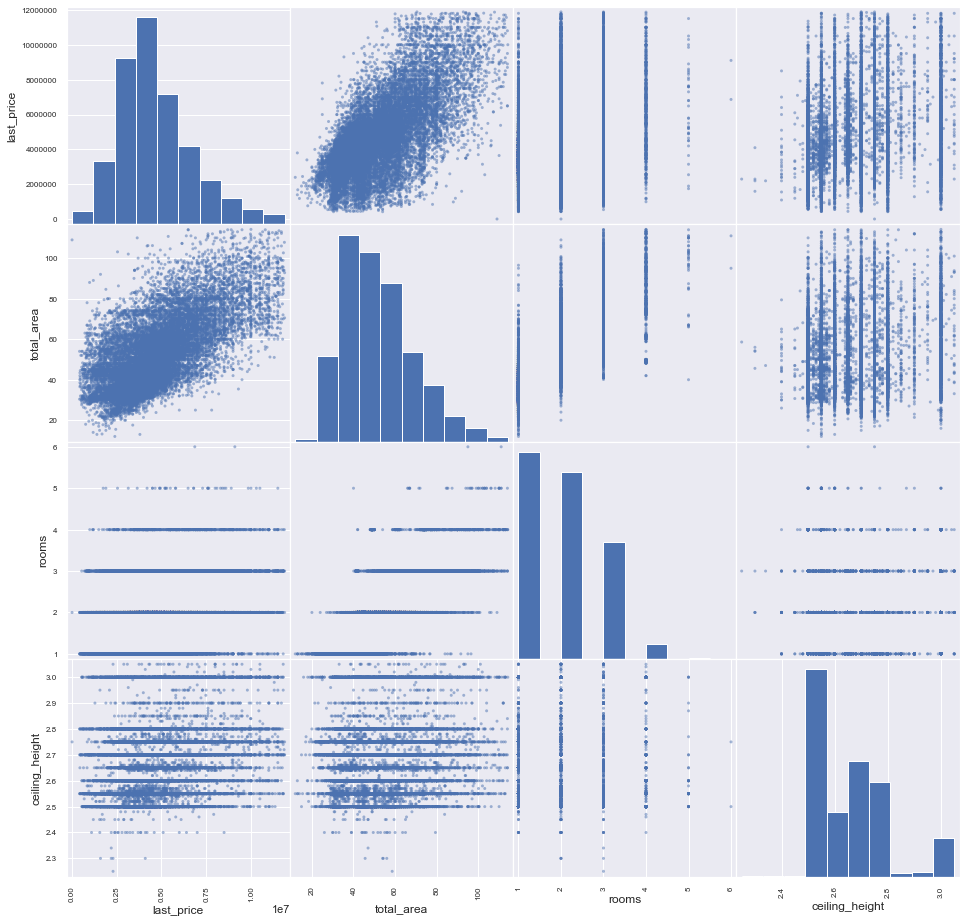

In [68]:
pd.plotting.scatter_matrix(good_data_stat, figsize=(16, 16));

Матрица корреляции и диаграмма рассеяния позволяют сделать следующие выводы:



Выделим ТОП-10 населенных пунктов выбоки по количеству объявлений:

In [69]:
median_m2_price = good_data.pivot_table(index='locality_name', values='price_per_m2', aggfunc=['count', 'median'])
median_m2_price.columns = ['count', 'median']
median_m2_price.sort_values(by='count', ascending=False).head(10)

,count,median
locality_name,,
Санкт-Петербург,12050,101923.076923
поселок Мурино,521,86075.949367
деревня Кудрово,435,96119.929453
посёлок Шушары,416,76666.666667
Всеволожск,359,65540.540541
посёлок Парголово,312,91387.362637
Колпино,311,74468.085106
Пушкин,298,98325.892857
Гатчина,274,67746.286082


Наибольшее количество квартир, вплоне ожидаемо, продается непосредственно в Санкт-Петербурге и ближайших пригородах.

Возглавляет рейтинг по цене за квадратный метр Санкт-Петербург с ценой порядка **101,9 тысячи** рублей.
Замыкает же ТОП-10 по цене Выбор с **57,6 тысячи** рублей за квадратный метр. Разброс пости в два раза объясняется удаленностью Выборга от Санкт-Петербурга на 140 километров.

Выделим в датафрейм *good_spb_flats* квартиры из очищенного датасета, находящиеся в Санкт-Петербурге и добавим к нему столбец *km_to_cityCenter*, в котором содержатся округленные до целых чисел значения километров от объекта недвижимости до центра города.

In [70]:
good_spb_flats = good_data.query('locality_name == "Санкт-Петербург"')
good_spb_flats['km_to_cityCenter'] = round(good_spb_flats['cityCenters_nearest'] / 1000, 0)

C:\Users\serg_\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


В *spb_flats_center_nearest* сохраним средние значения цены продажи квартиры для каждого километра по удалению от центра.

In [71]:
spb_flats_center_nearest = good_spb_flats.pivot_table(index='km_to_cityCenter', values='last_price')
spb_flats_center_nearest = spb_flats_center_nearest.reset_index()
spb_flats_center_nearest.head().astype(int)

,km_to_cityCenter,last_price
0,0,6466666
1,1,7749788
2,2,7634744
3,3,7193774
4,4,7177594


Построим график, отображающий зависимость средней цены продажи от расстояния до центра Санкт-Петербурга.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


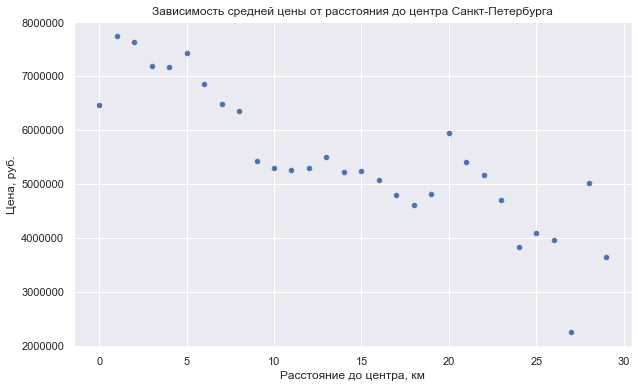

In [72]:
spb_flats_center_nearest.plot(x='km_to_cityCenter', y='last_price', kind='scatter', figsize=(10, 6))
plt.title('Зависимость средней цены от расстояния до центра Санкт-Петербурга')
plt.ylabel('Цена, руб.')
plt.xlabel('Расстояние до центра, км');

Видим ценовой разрыв между значениями 8 и 9 километров почти в миллион рублей. Будем считать, что именно **8 км** и есть тот самый радиус от центральной точки в городе, где самая дорогая недвижимость.

Более пристально рассмотрим квартиры, находящиеся в центре Санкт-Петербурга:

In [73]:
spb_center_flats = good_spb_flats.query('km_to_cityCenter <= 8')
spb_center_flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 1 to 19247
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   total_images               1863 non-null   int64         
 1   last_price                 1863 non-null   int32         
 2   total_area                 1863 non-null   float64       
 3   first_day_exposition       1863 non-null   datetime64[ns]
 4   rooms                      1863 non-null   int64         
 5   ceiling_height             1863 non-null   float64       
 6   floors_total               1861 non-null   float64       
 7   living_area                1863 non-null   float64       
 8   floor                      1863 non-null   int64         
 9   is_apartment               216 non-null    object        
 10  studio                     1863 non-null   bool          
 11  open_plan                  1863 non-null   bool          
 12  kitch

Изучим распределение значений по общей площади, цене, количеству комнат и высоте потолков в центре Санкт-Петербурга.

In [74]:
spb_center_flats['total_area'].describe()

count    1863.000000
mean       60.556758
std        20.162248
min        12.000000
25%        44.500000
50%        58.800000
75%        74.900000
max       114.200000
Name: total_area, dtype: float64

(0, 120)

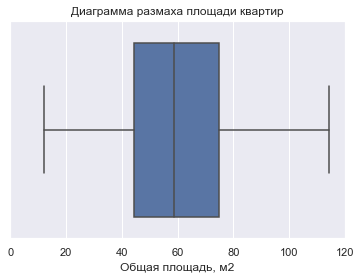

In [75]:
sns.boxplot(spb_center_flats['total_area'])
plt.title('Диаграмма размаха площади квартир')
plt.xlabel('Общая площадь, м2')
plt.xlim(0, 120)

Медианное значение площади квартиры в центре Санкт-Петербурга составляет **58,8 $м^{2}$**, что почти на 9 $м^{2}$ больше, чем медианное значение исходного датасета.

In [76]:
spb_center_flats['last_price'].describe()

count    1.863000e+03
mean     6.960916e+06
std      2.202091e+06
min      1.600000e+06
25%      5.300000e+06
50%      6.790000e+06
75%      8.500000e+06
max      1.187925e+07
Name: last_price, dtype: float64

(0, 14000000)

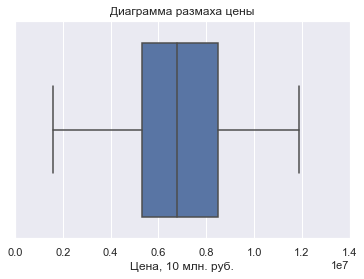

In [77]:
sns.boxplot(spb_center_flats['last_price'])
plt.title('Диаграмма размаха цены')
plt.xlabel('Цена, 10 млн. руб.')
plt.xlim(0, 14000000)

Медианное значение цены квартиры в центре Санкт-Петербурга составляет **6,79 млн. рублей**, что более чем на 2 миллиона больше медианы из исходного датасета. Жилье в центре ощутимо дороже, чем на окраинах и в области. Звучит логично.

(0, 7)

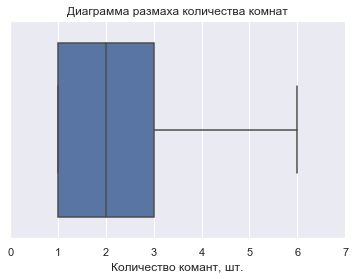

In [78]:
sns.boxplot(spb_center_flats['rooms'])
plt.title('Диаграмма размаха количества комнат')
plt.xlabel('Количество комант, шт.')
plt.xlim(0, 7)

Половина квартир, продающихся в центре Санкт-Петербурга - 1-комнатные или 2-комнатные, по этому показателю полное равенство с исходным датасетом.

In [79]:
spb_center_flats['ceiling_height'].describe()

count    1863.000000
mean        2.758760
std         0.185136
min         2.400000
25%         2.550000
50%         2.750000
75%         3.000000
max         3.050000
Name: ceiling_height, dtype: float64

(2.2, 3.2)

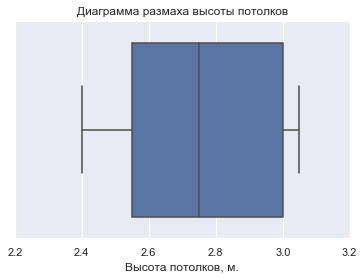

In [80]:
sns.boxplot(spb_center_flats['ceiling_height'])
plt.title('Диаграмма размаха высоты потолков')
plt.xlabel('Высота потолков, м.')
plt.xlim(2.2, 3.2)

Медианное значение высоты потолков в центре Санкт-Петербурга составляет **2,75 метра**, что на 10 сантиметров выше аналогичного показателя для исходного датасета. Та самая историческая застройка центральной части, о которой упоминалось выше.

Далее построим диаграммы размаха, чтобы оценить как соотносится цена квартиры с количеством комнат, категорией этажа, удаленностью от центра а также днем недели, месяцем и годом публикации объявления для квартир центрального района Санкт-Петербурга.

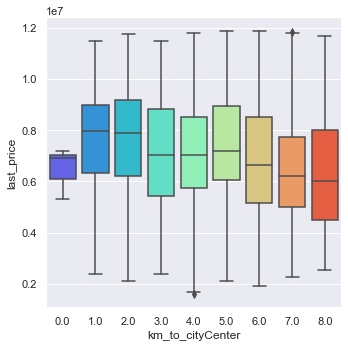

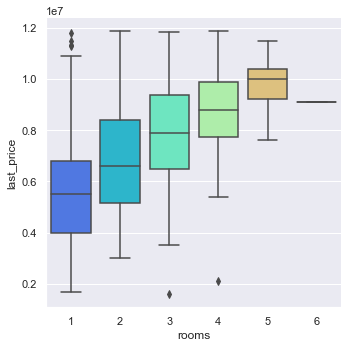

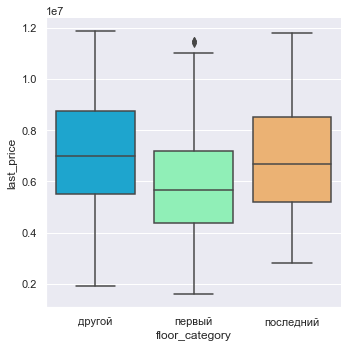

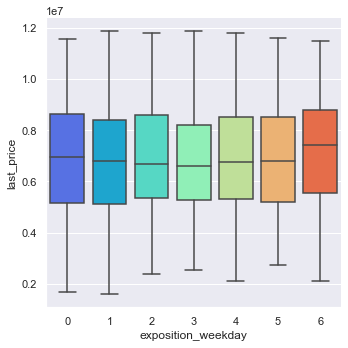

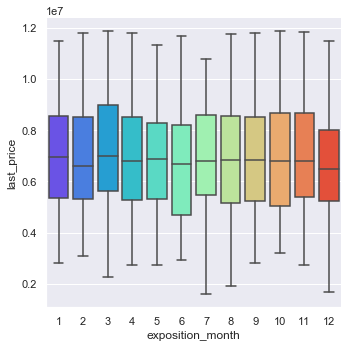

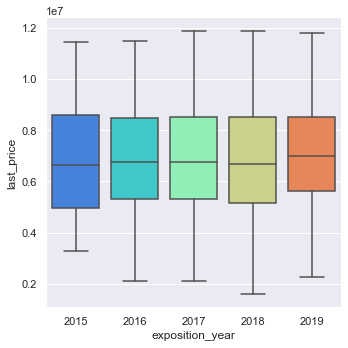

In [81]:
for column in ['km_to_cityCenter', 'rooms', 'floor_category', 'exposition_weekday', 'exposition_month', 'exposition_year']:
    sns.catplot(x=column, y="last_price", kind="box", data=spb_center_flats, palette='rainbow')

**Зависимость цены на недвижимость от удаленности от центра**
Можно разделить все квартиры центрального района на 3 радиуса:
- 0-2 километра (медианная цена в районе 8 млн. рублей);
- 3-5 километров (медианная цена в районе 7 миллионов рублей);
- 6-8 километров (медианная цена опускается с каждым километром от 6,5 до 6 млн. рублей).

**Зависимость цены на недвижимость от количества комнат**

В отличие от данных по всем квартирам есть отчетливая разница медианной цены между 3-комнатными и 4-комнатными квартирами. В то же время 6-комнатных квартир в выборке мало для того, чтобы дать объективную оценку их цене.

В целом же также прослеживается тенденция к росту цены с увеличением количества комнат.

**Зависимость цены на недвижимость от категории этажа**

В отличие от общих данных, в центре ярко выражена зависимость цены квартир на первых этажах. Они стоятпримерно на 0,5 млн. рублей дешевле, чем аналогичные варианты, как на последних, так и на любых других этажах.

**Зависимость цены на недвижимость от дня недели, месяца и года публикации**

Выбивается цена продажи для объявлений, опубликованных в воскресенье, при практически равных значениях для остальных дней недели. Скорей всего, это связано с малым количеством объявлений и является выбросом. По крайней мере рекомендовать к публикации квартиры в центре Санкт-Петербурга по воскресеньям для более высокой цены продажи не выглядит хорошей идеей.

Рассматривая зависимость цены от месяца публикации, замечаем, что центр города не так подвержен сезонному снижению, просадки в летние месяцы нет. В то же время зафиксировано увеличение цены в январе и марте. Без дополнительных данных сложно интерпретировать эти показатели.

В разрезе же нескольких лет можем сделать вывод, что цена на квартиры в центре города держится на стадильном уровне и не так подвержена изменениям, в зависимости от макроэкономических факторов, как цена на квартиры из полной выборки. 

Кроме того, отсутствуют данные за 2014 год для квартир центрального района, что не позволяет оценить поведение цен на квартиры во время ажиотажа на рынке недвижимости.

### Общий вывод

В данном проекте были проанализированы данные для определения зависимости цен на недвижимость в Санкт-Петербурге и Ленинградской области от разных факторов.

Для получения более качественной информации были заполнены пропуски, обработаны дубликаты, удалены редкие и выбивающиеся значения.

По итогам исследования можно сделать выводы, что цена на квартиру зависит от:
- общей площади;
- количества комнат;
- удаленности от центра;
- категории этажа (первый, последний, или любой другой);

Практически не зависит цена от дня недели и месяца публикации внутри года. Однако в разные годы цены меняются в зависимости от общих экономических трендов.

Особняком стоят квартиры в центре Санкт-Петербурга. На них стабильно высокий спрос, за счет чего они стоят дороже, а стоимость держится на стабильном уровне и устойчива к рыночным колебаниям.